In [2]:
from google.colab import drive
import os  
import pandas as pd  
import spacy  
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch.utils.tensorboard as tensorboard
import matplotlib.pyplot as plt

import string 
from torchtext.data.metrics import bleu_score

from PIL import Image  
import torchvision.transforms as transforms
import statistics
import torchvision.models as models
import torch.nn as nn 
import torch.optim as optim

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Opening datasets

In [ ]:
drive.mount("/content/gdrive/")

# import pandas as pd
textDirPath = "/content/gdrive/My Drive/Flickr8K/Flickr8k_text/" 
pathDirImage = "/content/gdrive/MyDrive/Flickr8K/Flicker8k_Images/"

tokenLemmaFile = pd.read_csv("/content/gdrive/My Drive/Flickr8K/Flickr8k_text/Flickr8k.lemma.token.txt",sep = "\t", on_bad_lines='skip' , header = None )
token = pd.read_csv("/content/gdrive/MyDrive/Flickr8K/Flickr8k_text/Flickr8k.token.txt",sep = "\t",on_bad_lines='skip', header = None)
validationData = pd.read_csv("/content/gdrive/MyDrive/Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt", on_bad_lines = 'skip', header = None)
trainingData = pd.read_csv("/content/gdrive/MyDrive/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt",on_bad_lines='skip', header = None)
testingData = pd.read_csv("/content/gdrive/MyDrive/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt",on_bad_lines='skip', header = None)

### Building Vocabulary 


In [3]:
def textRefining(tokenLemmaFile): 
  words  = []
  table = str.maketrans('', '', string.punctuation)
  curr = tokenLemmaFile.translate(table)
  curr = curr.lower() 
  curr = curr.split()
  return curr


In [4]:
# renaming columns with Image and caption
tokenLemmaFile = tokenLemmaFile.rename(columns = {0 : "Image" , 1 : "caption"})

# splitting using '#' token 
tokenLemmaFile["Image"] =[i.split('#')[0] for i in tokenLemmaFile["Image"].values ]


# drop the index column 

# validation file 
captionVal = tokenLemmaFile.where(tokenLemmaFile["Image"].isin(validationData[0].values) == True).dropna().reset_index().drop('index' , axis = 1)

# training file 
captionTrain = tokenLemmaFile.where(tokenLemmaFile["Image"].isin(trainingData[0].values) == True).dropna().reset_index().drop('index' , axis = 1)

# testing file
captionTest = tokenLemmaFile.where(tokenLemmaFile["Image"].isin(testingData[0].values) == True).dropna().reset_index().drop('index' , axis = 1)

In [ ]:
spacyEng = spacy.load("en")

In [6]:
# vocabulary class
class Vocabulary:
    def __init__(self, thresholdFreq):
        # stoi 
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        # itos 
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        # 
        self.thresholdFreq = thresholdFreq

    def __len__(self):
        return len(self.itos)

    # static function 
    @staticmethod
    def engTokenizer(text):
        return textRefining(text)

    def makeVocab(self, sentence_list):
        indices = 4
        frqs = {}

        for s in sentence_list:
            for word in self.engTokenizer(s):
                if word not in frqs:
                    frqs[word] = 1
                else:
                    frqs[word] += 1

                if frqs[word] == self.thresholdFreq:
                    self.stoi[word] = indices
                    self.itos[indices] = word
                    indices += 1



class CustomDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, thresholdFreq=5):
        self.root_dir = root_dir
        self.df = captions_file
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["Image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(thresholdFreq)
        self.vocab.makeVocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        filename = self.root_dir + "/" + img_id
        img = Image.open(filename)

        if self.transform is not None:
            img = self.transform(img)

        captionNum = [self.vocab.stoi["<SOS>"]]
        captionNum += self.vocab.numericalize(caption)
        captionNum.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(captionNum)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [ ]:
def GetLoader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    numWo = 8,
    shuffle=True,
    pin_memory=True,
):
    Dataset = CustomDataset(root_folder, annotation_file, transform=transform)

    pad_idx = Dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        Dataset=Dataset,
        batch_size=batch_size,
        numWo=numWo,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),]
)
# loader and dataset 
loader, Dataset = GetLoader(
    pathDirImage , captionTrain, transform=transform
)

In [7]:
class CNNEncoder(nn.Module):
    def __init__(self, embedSize, train_CNN=False):
        super(CNNEncoder, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embedSize)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))





In [ ]:
class RNNDecoder(nn.Module):
    def __init__(self, embedSize, HiddenLayerSize, VocabSize, numberOfLayer):
        super(RNNDecoder, self).__init__()
        self.embed = nn.Embedding(VocabSize, embedSize)
        self.lstm = nn.LSTM(embedSize, HiddenLayerSize, numberOfLayer)
        self.linear = nn.Linear(HiddenLayerSize, VocabSize)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        Output = self.linear(hiddens)
        return Output


In [ ]:
class CNNtoRNN(nn.Module):
    def __init__(self, embedSize, HiddenLayerSize, VocabSize, numberOfLayer):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = CNNEncoder(embedSize)
        self.decoderRNN = RNNDecoder(embedSize, HiddenLayerSize, VocabSize, numberOfLayer)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        Output = self.decoderRNN(features, captions)
        return Output

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[indices] for indices in result_caption]


In [8]:
def checkPointSaving(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def checkPointLoading(checkpoint, model, optimizer):
    print("Loading checkpoint... ")
    model.load_state_dict(checkpoint["state_dict"])
    # optimizer 
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
                                                 

epoch :  0


In [ ]:
# beam search 
import numpy as np
max_length = 10
def beam_search_predictions(image, beam_index = 3, wordtoix, ixtoword):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = 1
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:

def train():
    torch.backends.cudnn.benchmark = True
    saveModel = False
    train_CNN = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loadModel = False

    # Hyperparameters in the model
    embedSize = 256
    HiddenLayerSize = 256
    numberOfLayer = 1
    learningRate = 3e-4
    # number of epochs
    numEpochs = 10
    VocabSize = len(Dataset.vocab)

    # for tensorboard
    # flickr
    writer = SummaryWriter("runs/flickr")
    step = 0

    # MODEL
    model = CNNtoRNN(embedSize, HiddenLayerSize, VocabSize, numberOfLayer).to(device)
    
    technique = nn.CrossEntropyLoss(ignore_index=Dataset.vocab.stoi["<PAD>"])
    
    # adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learningRate)


    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if loadModel:
        step = checkPointLoading(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(100):

        if saveModel:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            checkPointSaving(checkpoint)

        for indices, (imgs, captions) in tqdm(enumerate(loader), total=len(loader), leave=False):
            imgs = imgs.to(device)
            captions = captions.to(device)

            Output = model(imgs, captions[:-1])
            loss = technique(
                Output.reshape(-1, Output.shape[2]), captions.reshape(-1)
            )
            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1
            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

    writer.close()
    return model 

model =  train()

In [10]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

loader, Dataset = GetLoader(
    pathDirImage , captionVal, transform=transform
)
lossesVal = [] 
for indices, (imgs, captions) in tqdm(
            enumerate(loader), total=len(loader), leave=False ):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            imgs = imgs.to(device)
            captions = captions.to(device)

            Output = model(imgs, captions[:-1])
            model.caption_image(imgs) 
            technique = nn.CrossEntropyLoss(ignore_index=Dataset.vocab.stoi["<PAD>"])
            loss = technique(
                Output.reshape(-1, Output.shape[2]), captions.reshape(-1)
            )
            lossesVal.append(loss)
            if indices % 500 : 
              print(loss)

losses = []
for i in lossesVal :
  losses.append(i.cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  1%|▏         | 2/157 [00:02<02:36,  1.01s/it]

tensor(5.2358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.1810, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 4/157 [00:02<01:11,  2.13it/s]

tensor(5.1845, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 5/157 [00:03<00:58,  2.60it/s]

tensor(5.2637, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.5350, device='cuda:0', grad_fn=<NllLossBackward0>)

  4%|▍         | 7/157 [00:03<00:41,  3.63it/s]


tensor(5.4226, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 8/157 [00:03<00:38,  3.91it/s]

tensor(5.2007, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 9/157 [00:04<00:54,  2.70it/s]

tensor(5.4070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.1060, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 12/157 [00:04<00:36,  3.94it/s]

tensor(5.4266, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2860, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 13/157 [00:05<00:35,  4.02it/s]

tensor(5.3755, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4543, device='cuda:0', grad_fn=<NllLossBackward0>)

  9%|▉         | 14/157 [00:05<00:33,  4.23it/s]

 10%|▉         | 15/157 [00:05<00:32,  4.39it/s]

tensor(5.4523, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|█         | 16/157 [00:05<00:32,  4.36it/s]

tensor(5.5052, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 17/157 [00:06<00:43,  3.20it/s]

tensor(5.3596, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 19/157 [00:06<00:35,  3.86it/s]

tensor(5.3457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3981, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 20/157 [00:06<00:33,  4.12it/s]

tensor(5.5546, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 21/157 [00:07<00:32,  4.12it/s]

tensor(5.3031, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▍        | 23/157 [00:07<00:30,  4.44it/s]

tensor(5.3085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3066, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 24/157 [00:07<00:32,  4.03it/s]

tensor(5.3533, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 26/157 [00:08<00:33,  3.86it/s]

tensor(5.2662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 28/157 [00:08<00:29,  4.44it/s]

tensor(5.3867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4355, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 29/157 [00:08<00:27,  4.62it/s]

tensor(5.4729, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 30/157 [00:09<00:28,  4.49it/s]

tensor(5.4738, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3503, device='cuda:0', grad_fn=<NllLossBackward0>)

 20%|█▉        | 31/157 [00:09<00:27,  4.54it/s]


tensor(5.3432, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 33/157 [00:09<00:26,  4.65it/s]

tensor(5.5839, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 34/157 [00:10<00:29,  4.14it/s]

tensor(5.5051, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 35/157 [00:10<00:28,  4.24it/s]

tensor(5.4020, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▎       | 37/157 [00:10<00:26,  4.61it/s]

tensor(5.2824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3432, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▍       | 39/157 [00:11<00:23,  4.95it/s]

tensor(5.1495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2915, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 40/157 [00:11<00:23,  4.98it/s]

tensor(5.4384, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 41/157 [00:11<00:34,  3.35it/s]

tensor(5.2313, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 42/157 [00:12<00:33,  3.41it/s]

tensor(5.3431, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3795, device='cuda:0', grad_fn=<NllLossBackward0>)

 28%|██▊       | 44/157 [00:12<00:27,  4.15it/s]


tensor(5.3437, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▊       | 45/157 [00:12<00:25,  4.42it/s]

tensor(5.2672, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 46/157 [00:12<00:24,  4.49it/s]

tensor(5.2856, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|██▉       | 47/157 [00:13<00:24,  4.51it/s]

tensor(5.1827, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 48/157 [00:13<00:25,  4.28it/s]

tensor(4.9948, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 49/157 [00:13<00:28,  3.83it/s]

tensor(5.3378, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 50/157 [00:13<00:27,  3.95it/s]

tensor(5.4290, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 52/157 [00:14<00:24,  4.37it/s]

tensor(5.3957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4126, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 53/157 [00:14<00:22,  4.58it/s]

tensor(5.3307, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 54/157 [00:14<00:22,  4.62it/s]

tensor(5.4244, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 56/157 [00:15<00:19,  5.06it/s]

tensor(5.3186, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4440, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 58/157 [00:15<00:24,  4.02it/s]

tensor(5.5378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3441, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 59/157 [00:15<00:22,  4.29it/s]

tensor(5.2607, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 61/157 [00:16<00:21,  4.54it/s]

tensor(5.4190, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3879, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 62/157 [00:16<00:20,  4.65it/s]

tensor(5.2085, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 64/157 [00:17<00:19,  4.71it/s]

tensor(5.3766, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3914, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████▏     | 65/157 [00:17<00:22,  4.07it/s]

tensor(5.3287, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 66/157 [00:17<00:27,  3.36it/s]

tensor(5.3685, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 67/157 [00:18<00:24,  3.66it/s]

tensor(5.4971, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 68/157 [00:18<00:22,  3.92it/s]

tensor(5.4816, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 69/157 [00:18<00:21,  4.16it/s]

tensor(5.2750, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 71/157 [00:18<00:19,  4.51it/s]

tensor(5.4025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4679, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 72/157 [00:19<00:19,  4.28it/s]

tensor(5.4699, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▋     | 73/157 [00:19<00:20,  4.15it/s]

tensor(5.2135, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 75/157 [00:19<00:18,  4.44it/s]

tensor(5.5170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3863, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 77/157 [00:20<00:16,  4.87it/s]

tensor(5.1579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3887, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|████▉     | 78/157 [00:20<00:16,  4.69it/s]

tensor(5.0797, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 79/157 [00:20<00:16,  4.67it/s]

tensor(5.2077, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 80/157 [00:20<00:17,  4.52it/s]

tensor(5.3620, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 81/157 [00:21<00:17,  4.33it/s]

tensor(5.3364, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 82/157 [00:21<00:24,  3.10it/s]

tensor(5.4895, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 83/157 [00:21<00:21,  3.44it/s]

tensor(5.4343, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 85/157 [00:22<00:17,  4.11it/s]

tensor(5.3459, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3136, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 86/157 [00:22<00:16,  4.38it/s]

tensor(5.4506, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▌    | 87/157 [00:22<00:15,  4.40it/s]

tensor(5.2537, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 88/157 [00:22<00:16,  4.23it/s]

tensor(5.3362, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 89/157 [00:23<00:16,  4.22it/s]

tensor(5.2995, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 91/157 [00:23<00:16,  4.01it/s]

tensor(5.4872, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4467, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 93/157 [00:24<00:14,  4.57it/s]

tensor(5.3249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2698, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|█████▉    | 94/157 [00:24<00:13,  4.69it/s]

tensor(5.4298, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 95/157 [00:24<00:13,  4.53it/s]

tensor(5.1871, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 96/157 [00:24<00:14,  4.27it/s]

tensor(5.3045, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 97/157 [00:25<00:14,  4.01it/s]

tensor(5.1991, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 98/157 [00:25<00:17,  3.41it/s]

tensor(5.4048, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 99/157 [00:25<00:16,  3.61it/s]

tensor(5.2594, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▎   | 100/157 [00:25<00:14,  3.82it/s]

tensor(5.0912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3261, device='cuda:0', grad_fn=<NllLossBackward0>)

 64%|██████▍   | 101/157 [00:26<00:13,  4.06it/s]

 65%|██████▍   | 102/157 [00:26<00:14,  3.88it/s]

tensor(4.9774, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 103/157 [00:26<00:13,  3.89it/s]

tensor(5.5461, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 104/157 [00:27<00:14,  3.55it/s]

tensor(5.5202, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 106/157 [00:27<00:13,  3.71it/s]

tensor(5.4329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4134, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 108/157 [00:27<00:11,  4.30it/s]

tensor(5.3618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2723, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 109/157 [00:28<00:10,  4.46it/s]

tensor(5.0879, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 111/157 [00:28<00:10,  4.60it/s]

tensor(5.1720, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3953, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████▏  | 112/157 [00:28<00:09,  4.68it/s]

tensor(5.5365, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 113/157 [00:29<00:10,  4.39it/s]

tensor(5.0934, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 115/157 [00:29<00:10,  3.92it/s]

tensor(5.2739, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3995, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▍  | 117/157 [00:30<00:09,  4.36it/s]

tensor(5.2097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4347, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 118/157 [00:30<00:08,  4.64it/s]

tensor(5.2973, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2546, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▋  | 120/157 [00:30<00:08,  4.50it/s]

tensor(5.4031, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 121/157 [00:31<00:08,  4.03it/s]

tensor(5.5297, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 122/157 [00:31<00:09,  3.55it/s]

tensor(5.1794, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 123/157 [00:31<00:09,  3.75it/s]

tensor(5.3654, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 125/157 [00:32<00:07,  4.44it/s]

tensor(5.3933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.5579, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 127/157 [00:32<00:06,  4.90it/s]

tensor(5.3132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2102, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 128/157 [00:32<00:06,  4.69it/s]

tensor(5.4908, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 129/157 [00:32<00:06,  4.31it/s]

tensor(5.2776, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 130/157 [00:33<00:07,  3.57it/s]

tensor(5.3317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2926, device='cuda:0', grad_fn=<NllLossBackward0>)

 83%|████████▎ | 131/157 [00:33<00:06,  3.89it/s]

 84%|████████▍ | 132/157 [00:33<00:06,  4.00it/s]

tensor(5.1158, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▌ | 134/157 [00:34<00:05,  4.53it/s]

tensor(5.3654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2460, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 135/157 [00:34<00:04,  4.67it/s]

tensor(5.1233, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 136/157 [00:34<00:04,  4.58it/s]

tensor(5.1821, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 137/157 [00:34<00:04,  4.68it/s]

tensor(5.1620, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 138/157 [00:35<00:05,  3.33it/s]

tensor(5.4322, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 140/157 [00:35<00:04,  3.94it/s]

tensor(5.3881, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4353, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|████████▉ | 141/157 [00:35<00:03,  4.04it/s]

tensor(5.4959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.1859, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 144/157 [00:36<00:02,  4.82it/s]

tensor(5.2240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4216, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 145/157 [00:36<00:02,  5.07it/s]

tensor(5.2720, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 146/157 [00:36<00:02,  4.97it/s]

tensor(5.3716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.1272, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▍| 149/157 [00:37<00:01,  6.77it/s]

tensor(5.2945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3719, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 151/157 [00:37<00:00,  7.25it/s]

tensor(5.3060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.1869, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2776, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▊| 155/157 [00:37<00:00, 10.06it/s]

tensor(5.6137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3500, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.2758, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3886, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 157/157 [00:38<00:00,  6.80it/s]

tensor(5.3306, device='cuda:0', grad_fn=<NllLossBackward0>)


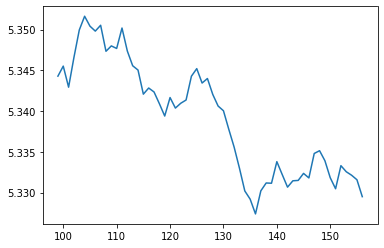

In [12]:
plt.plot(pd.Series(losses).rolling(100).mean().dropna())

In [27]:
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
import cv2 as cv
def print_tests(model, device, dataset):
   count = 0 
   
   for i in validationData[0].values :
     test_img = transform(Image.open(os.path.join(pathDirImage ,i))).unsqueeze(0)
     out_caption = model.caption_image(test_img.to(device), dataset.vocab)
     if count < 5:
       # ploiting first 5 images and their caption 
       plt.imshow(Image.open(os.path.join(pathDirImage ,i)))
       print(out_caption)
     count += 1
   print("Final Ouput: "+ " ".join(out_caption))


['<SOS>', 'a', 'car', 'in', 'a', 'his', 'hat', 'be', 'dress', 'man', 'a', 'someone', '<EOS>']
['<SOS>', 'a', 'car', 'in', 'a', 'his', 'hat', 'be', 'dress', 'man', 'a', 'someone', '<EOS>']
['<SOS>', 'a', 'car', 'in', 'a', 'his', 'hat', 'be', 'dress', 'man', 'a', 'someone', '<EOS>']
['<SOS>', 'a', 'car', 'in', 'a', 'his', 'hat', 'be', 'dress', 'man', 'a', 'someone', '<EOS>']
['<SOS>', 'a', 'car', 'in', 'a', 'his', 'hat', 'be', 'dress', 'man', 'a', 'someone', '<EOS>']
OUTPUT: <SOS> a car in a his hat be dress man a someone <EOS>


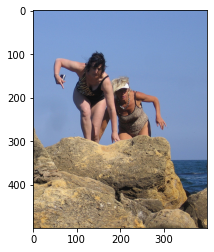

In [28]:
print_tests(model , device , Dataset)

In [15]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),]
)

Loader, Dataset = GetLoader(
    pathDirImage , captionTest, transform=transform
)

Output = []
for indices, (imgs, captions) in enumerate(Loader):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            imgs = imgs.to(device)
            captions = captions.to(device)

            Output = model(imgs, captions[:-1])
            
            technique = nn.CrossEntropyLoss(ignore_index=Dataset.vocab.stoi["<PAD>"])
            loss = technique(
                Output.reshape(-1, Output.shape[2]), captions.reshape(-1)
            )
            lossesVal.append(loss)
            # if indices % 500 :

Dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## calculating bleu score

In [ ]:
captionVal.iloc[1 , 0]

# calculating bleu score
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),]
)

# fet loader and Dataset from 
loader, Dataset = GetLoader(
    pathDirImage , captionVal, transform=transform
)

for indices, (imgs, captions) in enumerate(loader):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            imgs = imgs.to(device)
            captions = captions.to(device)

            Output = model(imgs, captions[:-1])
            caption = model.caption_image(imgs.to(device), Dataset.vocab)
            bleu_score(caption.reshape(-1, Output.shape[2]), captions.reshape(-1))